In [3]:

"""
sanity check for the reconstruction loss
"""
import torch
from flextok.flextok_wrapper import FlexTokFromHub
from diffusers.models import AutoencoderKL
from flextok.utils.demo import imgs_from_urls
import matplotlib.pyplot as plt
from data.utils.dataloaders import get_imagenet_dataloader
from reconstruction_loss import MAELoss, reconstructionLoss_vs_compressionRate, VGGPerceptualLoss
from collections import defaultdict
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# this model contains the VAE and the denoiser
model = FlexTokFromHub.from_pretrained('EPFL-VILAB/flextok_d18_d28_in1k').eval().to(device)
imgnet_dataloader = get_imagenet_dataloader(batch_size=8)

/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
first_batch = next(iter(imgnet_dataloader))

In [ ]:
original_imgs = first_batch[0]

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

imgs = original_imgs * IMAGENET_STD + IMAGENET_MEAN
imgs = imgs.clamp(0, 1)

fig, axes = plt.subplots(imgs.shape[0], 1, figsize=(35, 10))
for i in range(imgs.shape[0]):
    axes[i].imshow(imgs[i].permute(1, 2, 0).cpu())
    axes[i].axis('off')
plt.show()

In [ ]:

amount_images = 28  # Number of images to process
k_keep_list = [1, 2, 4, 8, 16, 32, 64, 128, 180, 256]  # Different compression rates to test
loss_fns = [VGGPerceptualLoss().to(device), MAELoss()] 
batch_size = 8
results =[]
for i in range(amount_images // batch_size):
    first_batch = next(iter(imgnet_dataloader))[0]
    result = reconstructionLoss_vs_compressionRate(model, first_batch.to(device), k_keep_list, loss_fns, device, loss_weights=None)
    results.append(result)

In [4]:
# Initialize a dictionary to store concatenated results for each k value
concatenated_results = defaultdict(lambda: defaultdict(list))
# Iterate through each batch in results
for batch_result in results:
    # iterate through each k and its corresponding loss_dict
    for k, loss_dict_reconIMG in batch_result.items():
        # ignore the image, just fetch the errors
        for loss_name, loss_tensor in loss_dict_reconIMG[0].items():
            # Extend the list for the corresponding k and loss type
            concatenated_results[k][loss_name].extend(loss_tensor)

In [5]:
k_values = list(results.keys())
reconstructed_imgs = {}
for k in k_values:
    reconstructed_imgs[k] = results[k][1]

def save_img_grid(reconstructed_imgs, output_path):
    # the grid will have num_rows rows and num_cols columns
    # such that columns represents the different k values
    # and rows represent the different images in the batch
    num_cols = len(reconstructed_imgs.keys())
    num_rows = len(reconstructed_imgs[1])
    print(f"Number of rows: {num_rows}, Number of columns: {num_cols}")

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
   
    for col, k in enumerate(reconstructed_imgs.keys()):
        imgs = reconstructed_imgs[k].cpu()

        # If images are in (B, C, H, W), convert to (H, W, C) for plotting
        imgs = imgs.permute(0, 2, 3, 1)
        for row in range(num_rows):
            ax = axes[row, col]
            ax.imshow(imgs[row].numpy())
            ax.axis('off')
            if row == 0:
                ax.set_title(f'k={k}')

    plt.tight_layout()
    plt.savefig(output_path)
    plt.close(fig)

save_img_grid(reconstructed_imgs, "recon.pdf")

AttributeError: 'list' object has no attribute 'keys'

In [38]:
concatenated_results.keys()  # This will give you the k values used in the reconstruction
concatenated_results[1].keys()

dict_keys(['VGGPerceptualLoss', 'MAELoss'])

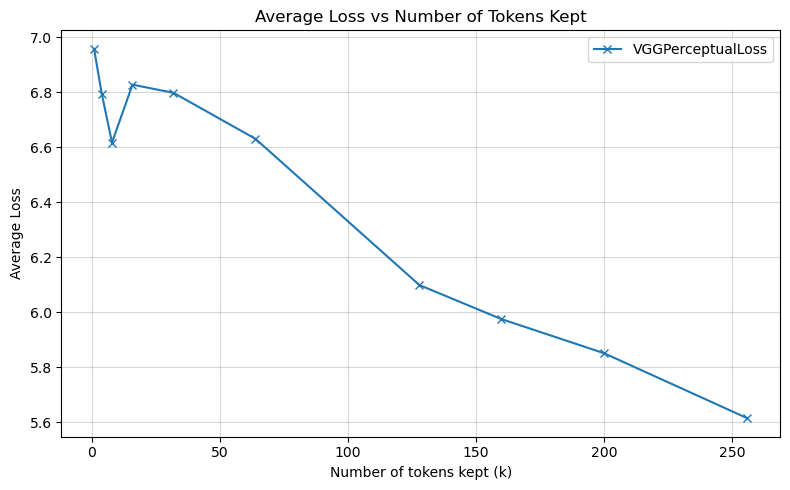

In [6]:
# plot k vs loss, where k is the number of tokens kept and it is the x-axis
# y axis is the loss, and it is plotting both the VGG and MAE losses
k_values = list(concatenated_results.keys())

mae_means = []
vgg_means = []

for k in concatenated_results.keys():
    vgg_mean = torch.tensor(concatenated_results[k]["VGGPerceptualLoss"]).mean().item()
    mae_mean = torch.tensor(concatenated_results[k]["MAELoss"]).mean().item()

    mae_means.append(mae_mean)
    vgg_means.append(vgg_mean)

plt.figure(figsize=(8, 5))
plt.plot(k_values, vgg_means, marker='x', label='VGGPerceptualLoss')
plt.xlabel('Number of tokens kept (k)')
plt.ylabel('Average Loss')
plt.title('Average Loss vs Number of Tokens Kept')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

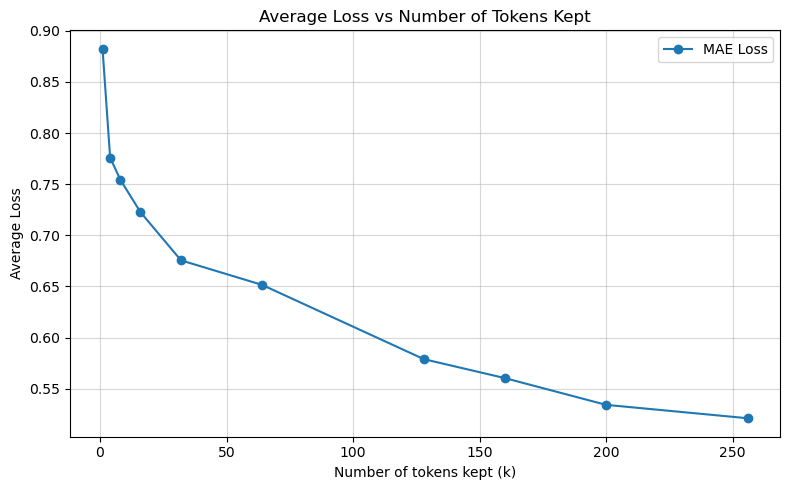

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, mae_means, marker='o', label='MAE Loss')
plt.xlabel('Number of tokens kept (k)')
plt.ylabel('Average Loss')
plt.title('Average Loss vs Number of Tokens Kept')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example compression rate to plot
k_keep_to_plot = 64  # Change this to the desired k_keep value

for k_keep_to_plot in k_keep_list:
   
    # Extract MAE and VGG loss values for the given compression rate
    mae_losses = concatenated_results[k_keep_to_plot]['MAELoss'].cpu().numpy()  # Convert to numpy for plotting
    #vgg_losses = concatenated_results[k_keep_to_plot]['VGGPerceptualLoss'].cpu().numpy()  # Convert to numpy for plotting

    # Generate image labels (x-axis)
    image_labels = np.arange(len(mae_losses))  # Assuming one loss value per image

    # Plot the losses
    plt.figure(figsize=(12, 6))
    plt.plot(image_labels, mae_losses, label='MAE Loss', marker='o', color='blue')
    #plt.plot(image_labels, vgg_losses, label='VGG Loss', marker='x', color='orange')

    # Add labels, title, and legend
    plt.xlabel('Image Label')
    plt.ylabel('Loss')
    plt.title(f'MAE and VGG Loss for Compression Rate k_keep={k_keep_to_plot}')
    plt.legend()
    plt.grid(alpha=0.5)

    # Show the plot
    plt.tight_layout()
    plt.show()

# 

: 